In [22]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter, KaplanMeierFitter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
# Load data
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
df.info()
print(df.isnull().sum())

# Prepare the dataset for survival analysis
## Create the PromotionEvent column
df['PromotionEvent'] = df.apply(lambda row: 0 if row['YearsSinceLastPromotion'] == row['YearsInCurrentRole'] else 1, axis=1)

## Bin the categorial variable
df['NumCompaniesWorked_bin'] = pd.cut(df['NumCompaniesWorked'], bins=[-1, 0, 1, 3, float('inf')], labels=['0', '1', '2-3', '4+']).astype('category')
df['TotalWorkingYears_bin'] = pd.cut(df['TotalWorkingYears'], bins=[-1, 5, 10, 20, float('inf')], labels=['0-5', '6-10', '11-20', '21+']).astype('category')
df['YearsInCurrentRole_bin'] = pd.cut(df['YearsInCurrentRole'], bins=[-1, 2, 5, 10, float('inf')], labels=['0-2', '3-5', '6-10', '11+']).astype('category')
df['YearsWithCurrManager_bin'] = pd.cut(df['YearsWithCurrManager'], bins=[-1, 2, 5, 10, float('inf')], labels=['0-2', '3-5', '6-10', '11+']).astype('category')

## Define feature list
features = ['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction',
            'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'NumCompaniesWorked',
            'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
            'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
            'WorkLifeBalance', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

## Define formula
formula = ' + '.join(features) + ' + C(NumCompaniesWorked_bin) + C(TotalWorkingYears_bin) + C(YearsInCurrentRole_bin) + C(YearsWithCurrManager_bin)'


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [23]:
# Prepare dataframe for Cox model
df_cox = df[features + ['NumCompaniesWorked_bin', 'TotalWorkingYears_bin', 'YearsInCurrentRole_bin', 'YearsWithCurrManager_bin', 'PromotionEvent', 'YearsAtCompany']].dropna()

# Fit the Cox Proportional Hazards model
cph = CoxPHFitter()
cph.fit(df_cox, duration_col='YearsAtCompany', event_col='PromotionEvent', formula=formula)

# Print the summary of the model
cph.print_summary()

# Get the summary dataframe
summary = cph.summary

<lifelines.CoxPHFitter: fitted with 1470 total observations, 391 right-censored observations>
             duration col = 'YearsAtCompany'
                event col = 'PromotionEvent'
      baseline estimation = breslow
   number of observations = 1470
number of events observed = 1079
   partial log-likelihood = -5628.63
         time fit was run = 2024-06-22 06:27:57 UTC

---
                                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                            
Age                                  0.01      1.01      0.01           -0.00            0.02                1.00                1.02
DailyRate                            0.00      1.00      0.00           -0.00            0.00                1.00                1.00
DistanceFromHome                     0.00      1.00      0.00           -0.00            0.01                1.00                1.01
Education                           -0.04      0.96      0.03           -0.10            0.02                0.90                1.02
EnvironmentSatisfaction             -0.00      1.00      0.03           -0.06            0.06                0.94                1.06
JobInvolvement                       0.04      1.04      0.05           -0.05            0.13                0.95                1.14
JobLevel                            -0.22      0.80      0.09           -0.40           -0.04                0.67                0.96
JobSatisfaction                     -0.09      0.92      0.03           -0.14           -0.03                0.87                0.97
MonthlyIncome                        0.00      1.00      0.00           -0.00            0.00                1.00                1.00
NumCompaniesWorked                  -0.02      0.98      0.03           -0.09            0.04                0.92                1.04
PercentSalaryHike                    0.02      1.02      0.01           -0.01            0.04                0.99                1.04
PerformanceRating                   -0.02      0.98      0.14           -0.29            0.25                0.75                1.28
RelationshipSatisfaction             0.00      1.00      0.03           -0.06            0.06                0.94                1.06
StockOptionLevel                    -0.00      1.00      0.04           -0.07            0.07                0.93                1.08
TotalWorkingYears                   -0.19      0.82      0.02           -0.23           -0.16                0.80                0.85
TrainingTimesLastYear                0.00      1.00      0.02           -0.04            0.05                0.96                1.05
WorkLifeBalance                      0.01      1.01      0.04           -0.07            0.10                0.93                1.10
YearsInCurrentRole                  -0.04      0.96      0.03           -0.10            0.02                0.91                1.02
YearsSinceLastPromotion             -0.10      0.90      0.01           -0.12           -0.08                0.88                0.92
YearsWithCurrManager                -0.08      0.92      0.03           -0.14           -0.02                0.87                0.98
C(NumCompaniesWorked_bin)[T.1]      -0.47      0.63      0.10           -0.67           -0.27                0.51                0.76
C(NumCompaniesWorked_bin)[T.2-3]     1.32      3.76      0.14            1.05            1.60                2.85                4.96
C(NumCompaniesWorked_bin)[T.4+]      1.00      2.71      0.22            0.56            1.44                1.75                4.20
C(TotalWorkingYears_bin)[T.6-10]    -1.07      0.34      0.13           -1.32           -0.82                0.27                0.44
C(TotalWorkingYears_bin)[T.11-20]   -1.06      0.35      0.20           -1.46           -0.66                0.23                0.52
C(

The variables with a strong association with promotion are: ['JobLevel', 'JobSatisfaction', 'TotalWorkingYears', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'C(NumCompaniesWorked_bin)[T.1]', 'C(NumCompaniesWorked_bin)[T.2-3]', 'C(NumCompaniesWorked_bin)[T.4+]', 'C(TotalWorkingYears_bin)[T.6-10]', 'C(TotalWorkingYears_bin)[T.11-20]', 'C(TotalWorkingYears_bin)[T.21+]', 'C(YearsInCurrentRole_bin)[T.3-5]', 'C(YearsInCurrentRole_bin)[T.6-10]', 'C(YearsInCurrentRole_bin)[T.11+]', 'C(YearsWithCurrManager_bin)[T.6-10]', 'C(YearsWithCurrManager_bin)[T.11+]']


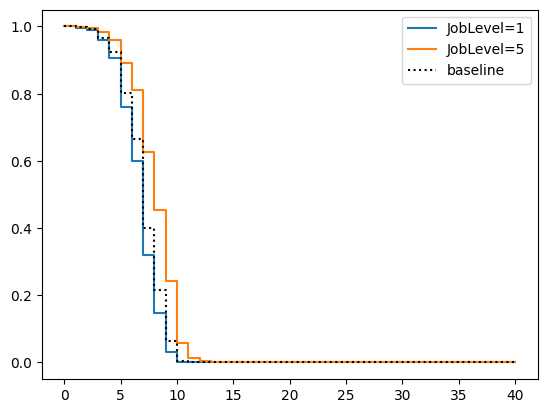


   Bootstrapping lowess lines. May take a moment...

The ``p_value_threshold`` is set at 0.01. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 1470 total observations, 391 right-censored observations>
         test_name = proportional_hazard_test

---
                                          test_statistic      p  -log2(p)
Age                                 km              8.27 <0.005      7.95
                                    rank            7.18   0.01      7.09
C(NumCompaniesWorked_bin)[T.1]      km              0.14   0.71      0.49
                                    rank            0.20   0.66      0.61
C(NumCompaniesWorked_bin)[T.2-3]    km              8.56 <0.005      8.18
                                    rank            9.53 <0.005      8.95
C(NumCompaniesWorked_bin)[T.4+]     km              1.73   0.19      2.41
                                    rank            2.05   0.15      2.72
C(TotalWorkingYears_bin)[T.11-20]   km              5.59   0.02      5.79
                                    rank            4.00   0.05      4.46
C(TotalWorkingYears_bin)[T.21+]     km             21.06 <0.005     17.77
                                    rank           18.29 <0.005     15.69
C(TotalWorkingYears_bin)[T.6-10]    km              0.07   0.80      0.33
                                    rank            0.31   0.58      0.79
C(YearsInCurrentRole_bin)[T.11+]    km             10.77 <0.005      9.92
                                    rank           11.49 <0.005     10.48
C(YearsInCurrentRole_bin)[T.3-5]    km             25.82 <0.005     21.35
                                    rank           24.65 <0.005     20.47
C(YearsInCurrentRole_bin)[T.6-10]   km             18.78 <0.005     16.06
                                    rank           19.68 <0.005     16.74
C(YearsWithCurrManager_bin)[T.11+]  km              1.30   0.25      1.98
                                    rank            1.69   0.19      2.37
C(YearsWithCurrManager_bin)[T.3-5]  km              8.81 <0.005      8.38
                                    rank            8.19 <0.005      7.89
C(YearsWithCurrManager_bin)[T.6-10] km              4.48   0.03      4.86
                                    rank            5.15   0.02      5.43
DailyRate                           km              0.01   0.92      0.12
                                    rank            0.01   0.94      0.09
DistanceFromHome                    km              0.67   0.41      1.28
                                    rank            0.65   0.42      1.25
Education                           km              1.96   0.16      2.63
                                    rank            2.12   0.15      2.78
EnvironmentSatisfaction             km              1.01   0.32      1.66
                                    rank            1.32   0.25      1.99
JobInvolvement                      km              1.07   0.30      1.74
                                    rank            0.91   0.34      1.55
JobLevel                            km              0.44   0.51      0.99
                                    rank            0.36   0.55      0.86
JobSatisfaction                     km              2.85   0.09      3.46
                                    rank            2.40   0.12      3.05
MonthlyIncome                       km              2.10   0.15      2.76
                                    rank            1.75   0.19      2.43
NumCompaniesWorked                  km              1.43   0.23      2.10
                                    rank            1.60   0.21      2.28
PercentSalaryHike                   km              2.09   0.15      2.75
                                    rank            1.78   0.18      2.46
PerformanceRating                   km              1.35   0.25      2.02
                                    rank            1.02   0.31      1.67
RelationshipSatisfaction            km              0.02   0.89      0.16
                      



1. Variable 'Age' failed the non-proportional test: p-value is 0.0040.

   Advice 1: the functional form of the variable 'Age' might be incorrect. That is, there may be
non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'Age' using pd.cut, and then specify it in `strata=['Age',
...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment..

/opt/anaconda3/lib/python3.11/site-packages/lifelines/fitters/mixins.py:123: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()



   Bootstrapping lowess lines. May take a moment...


4. Variable 'C(NumCompaniesWorked_bin)[T.2-3]' failed the non-proportional test: p-value is 0.0020.

   Advice: with so few unique values (only 2), you can include
`strata=['C(NumCompaniesWorked_bin)[T.2-3]', ...]` in the call in `.fit`. See documentation in link
[E] below.

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


5. Variable 'C(TotalWorkingYears_bin)[T.21+]' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few unique values (only 2), you can include
`strata=['C(TotalWorkingYears_bin)[T.21+]', ...]` in the call in `.fit`. See documentation in link
[E] below.

   Bootstrapping lowess lines. May take a moment...


6. Variable 'C(YearsInCurrentRole_bin)[T.3-5]' failed the non-proportional test: p-value is <5e-05.

   Advice: with so few u

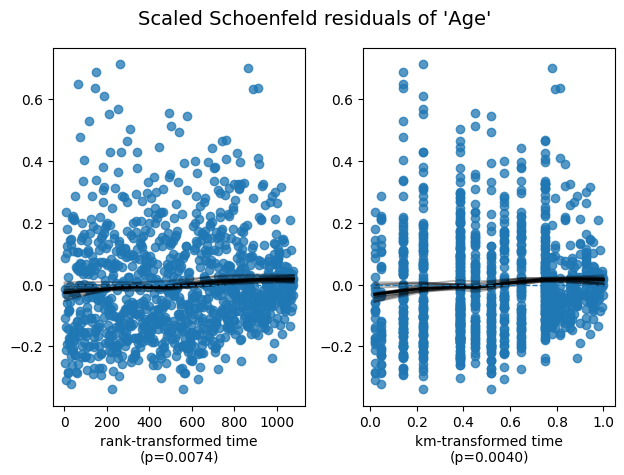

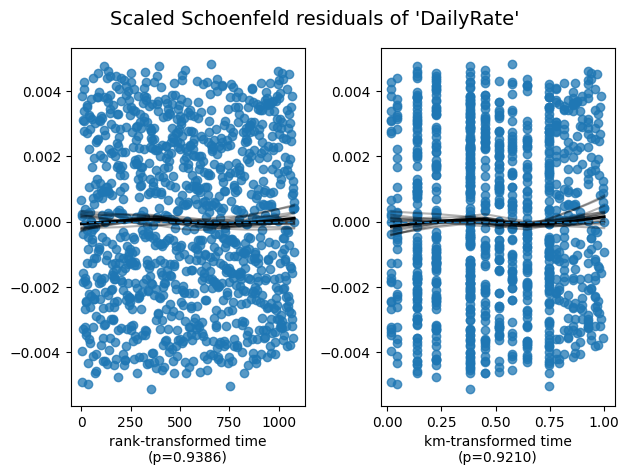

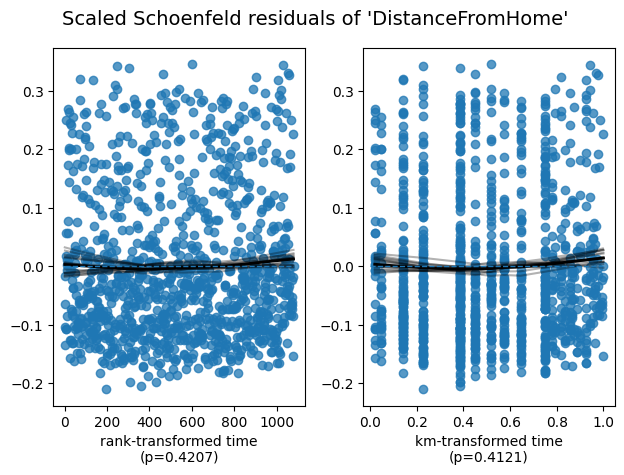

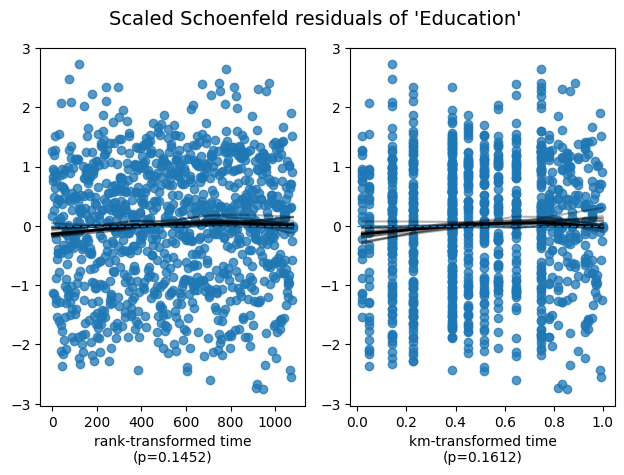

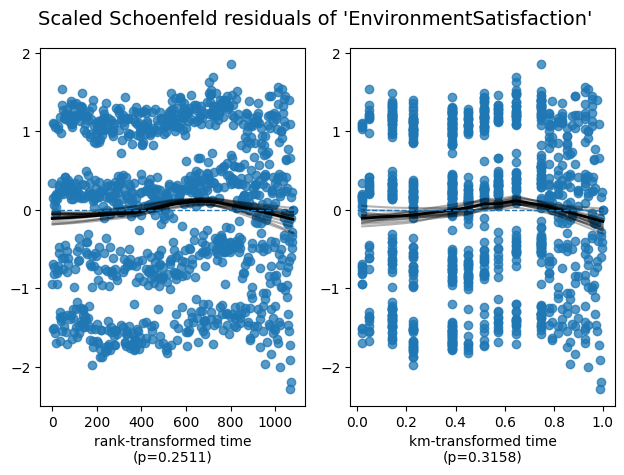

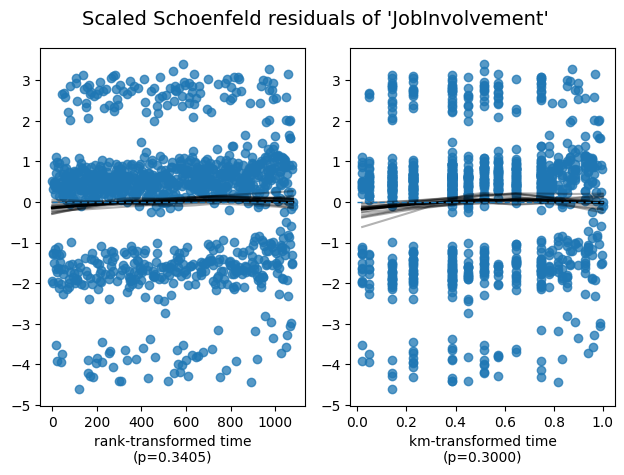

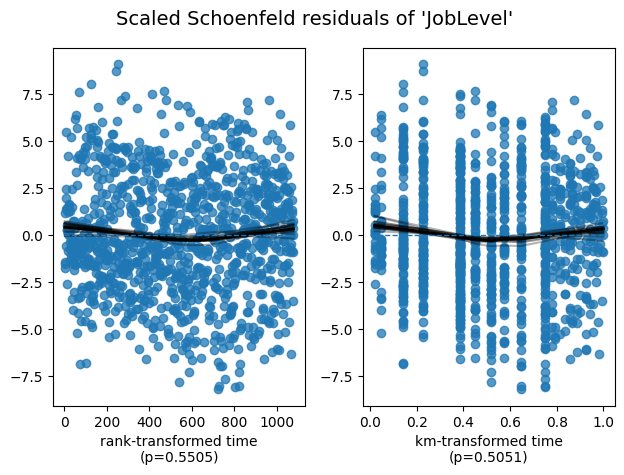

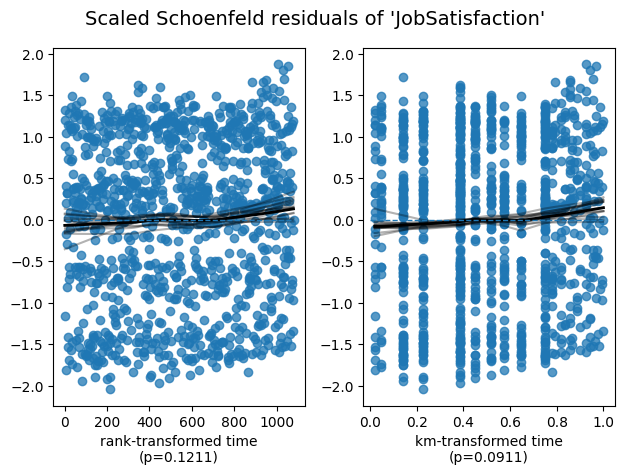

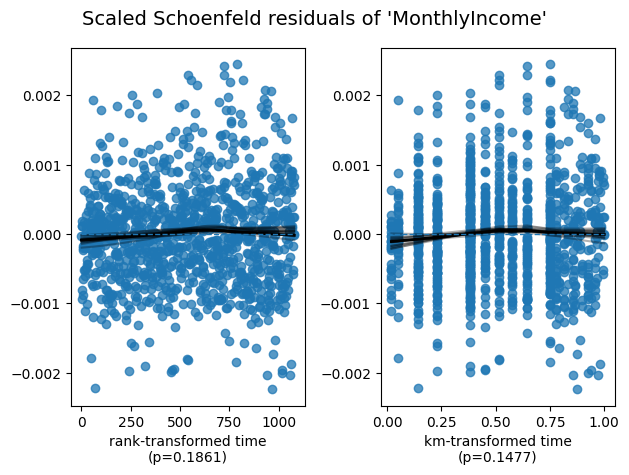

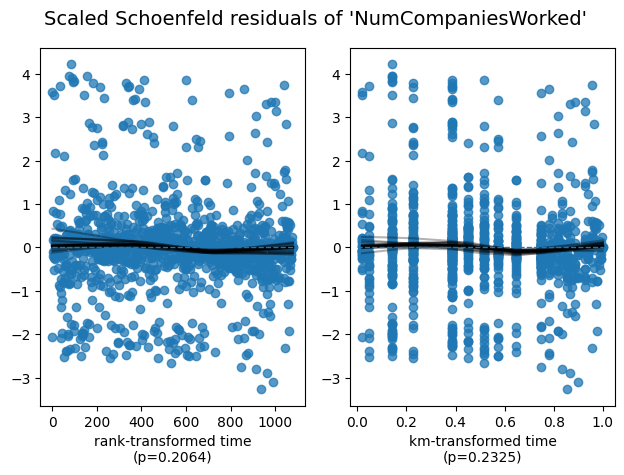

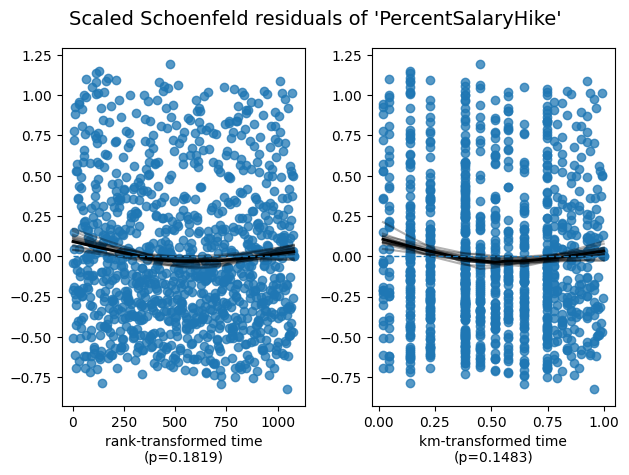

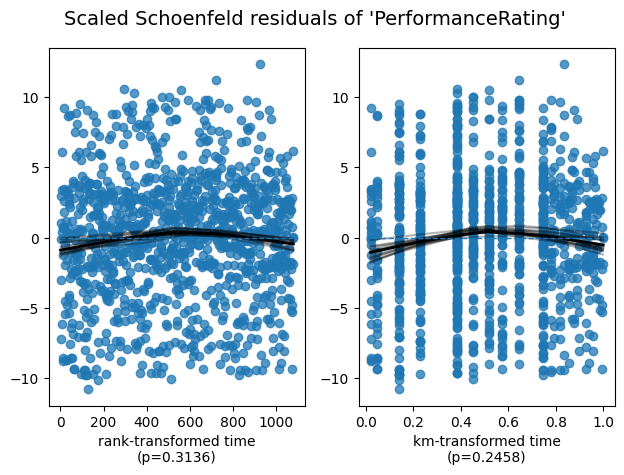

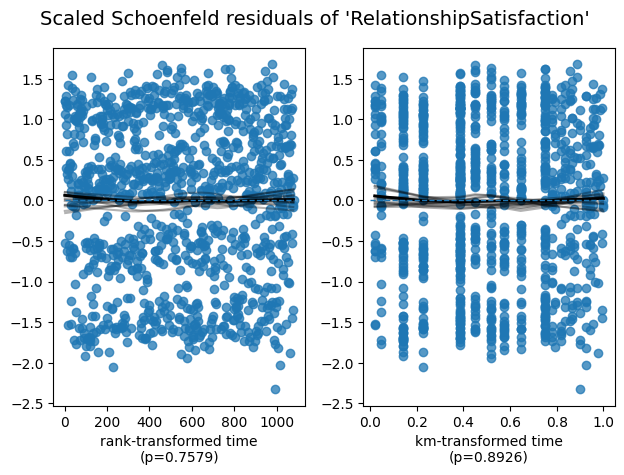

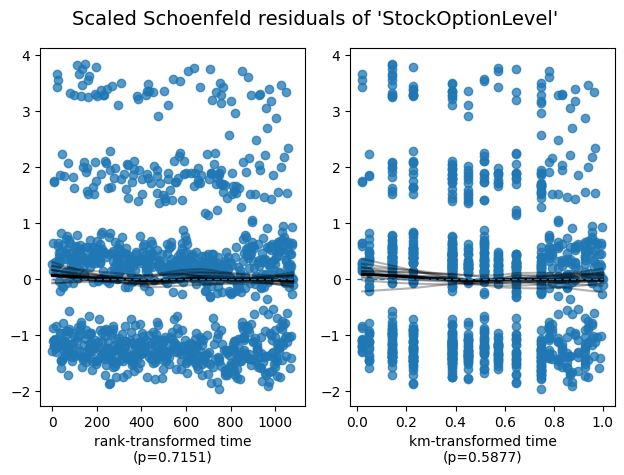

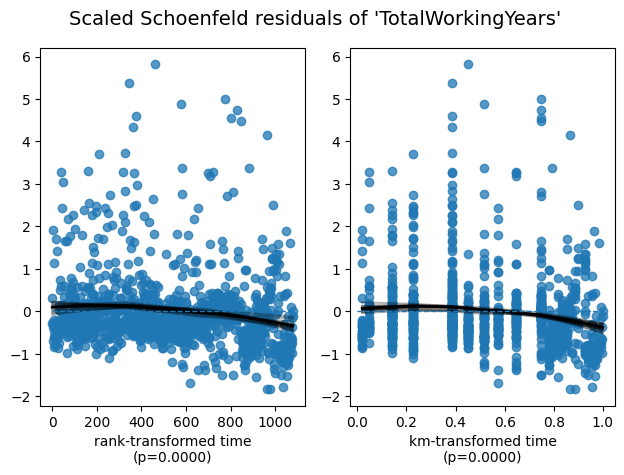

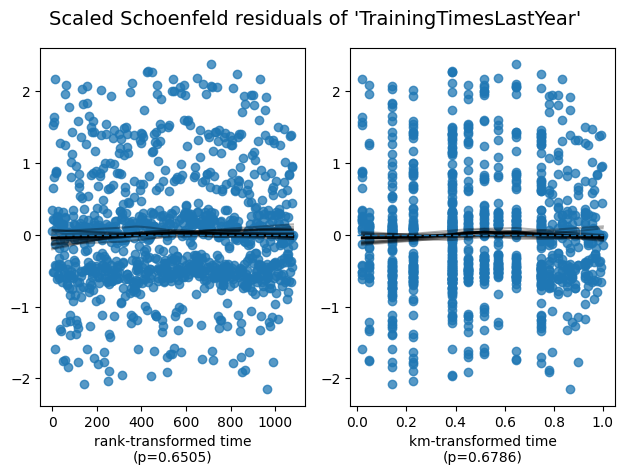

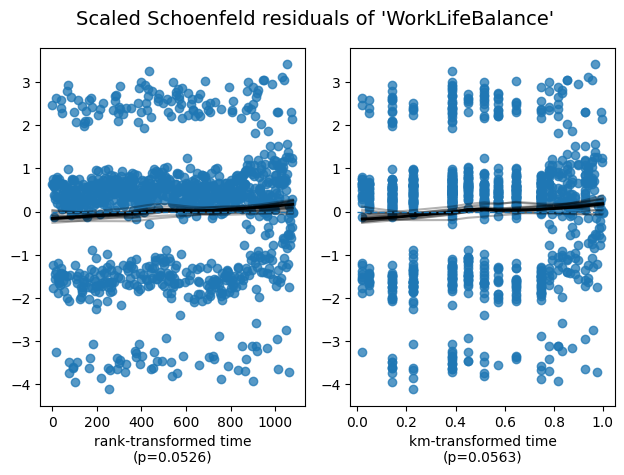

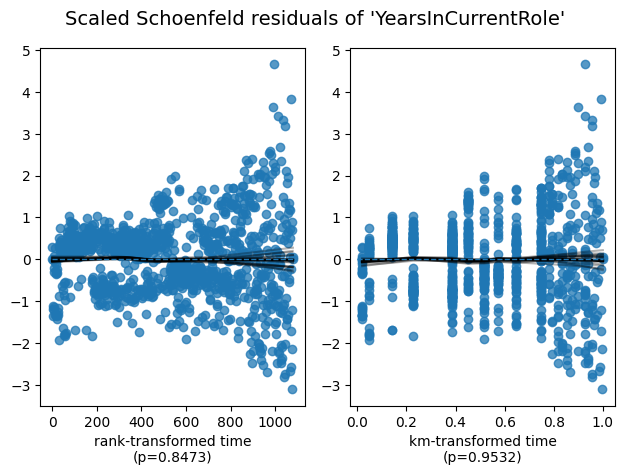

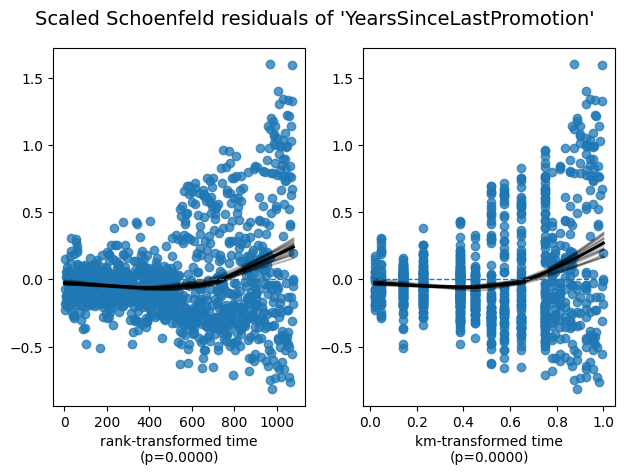

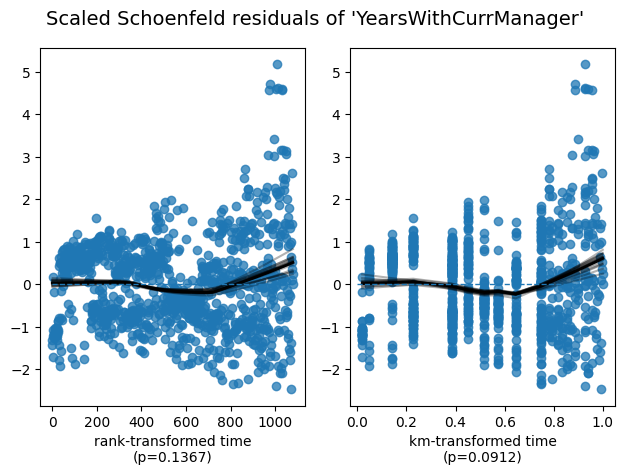

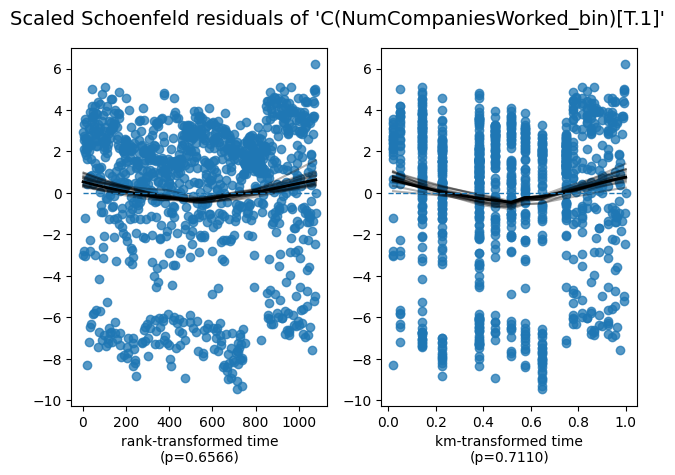

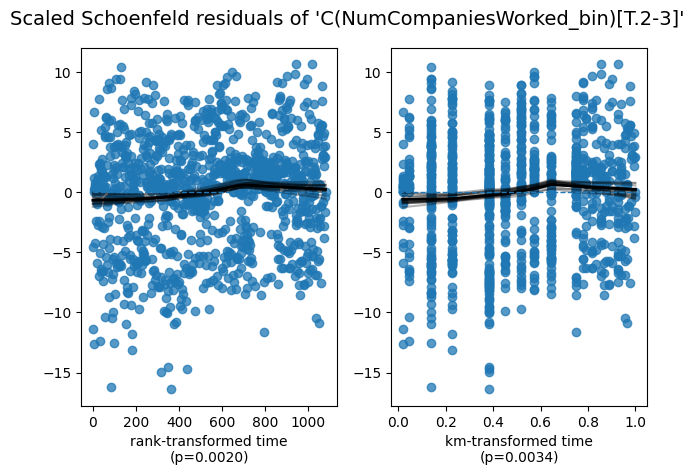

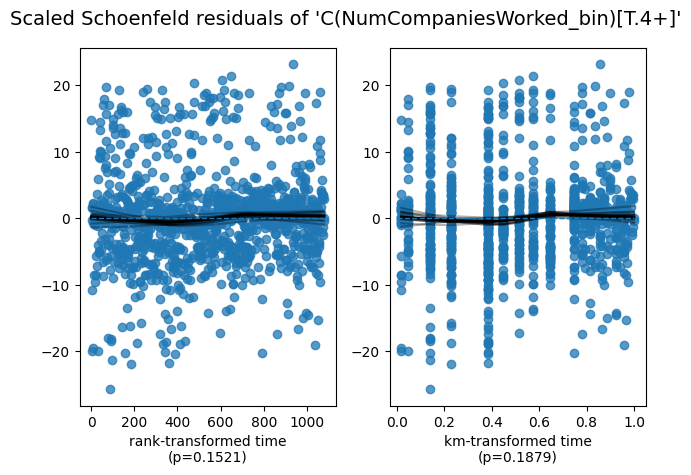

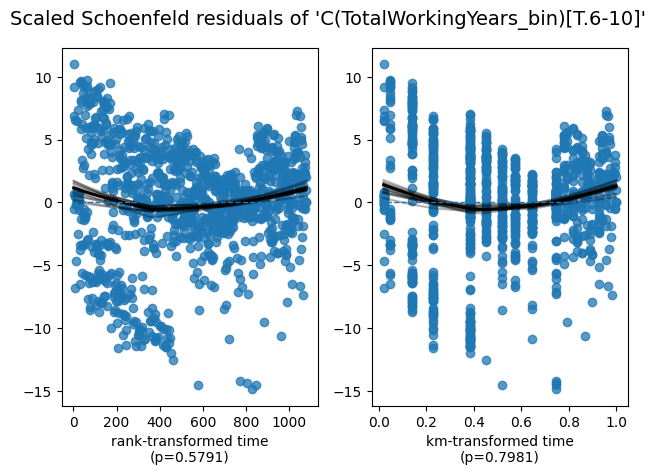

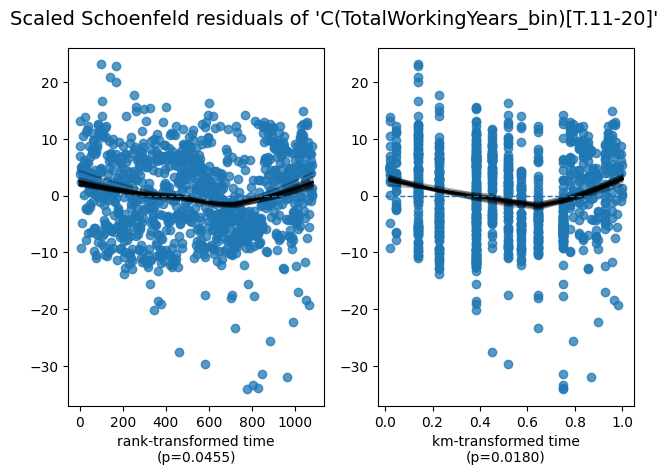

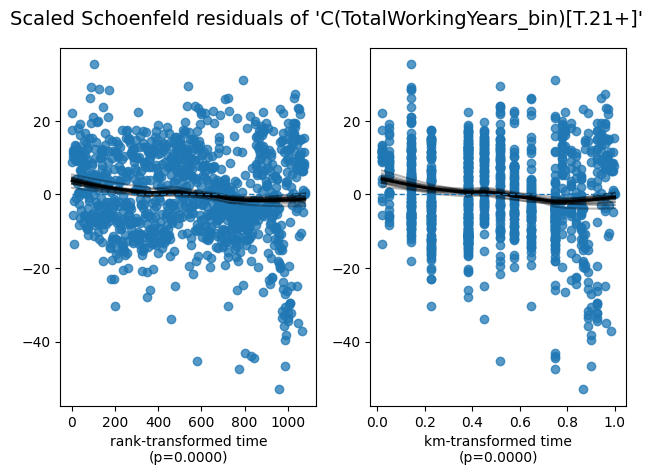

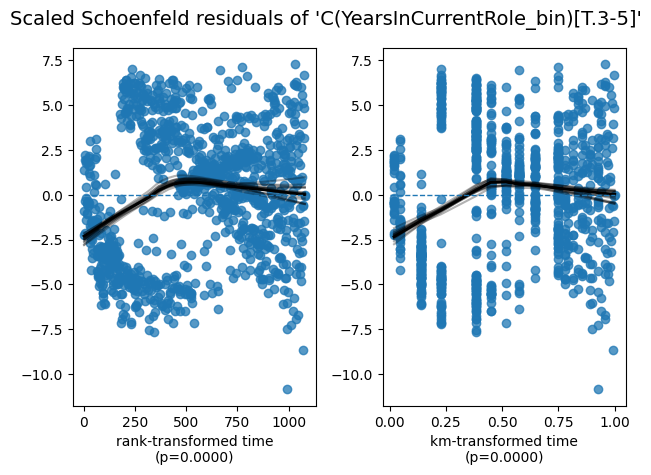

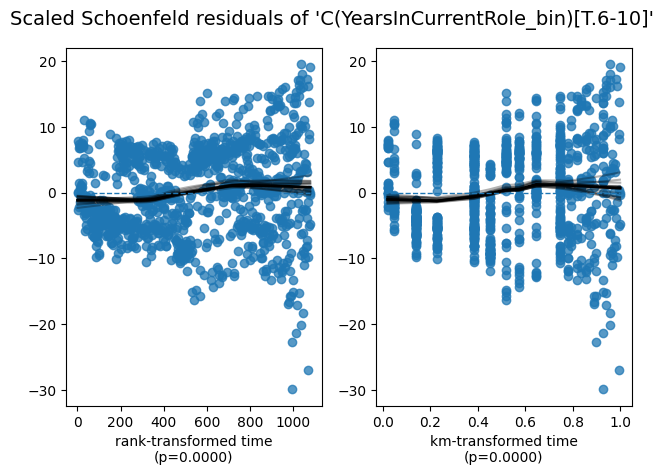

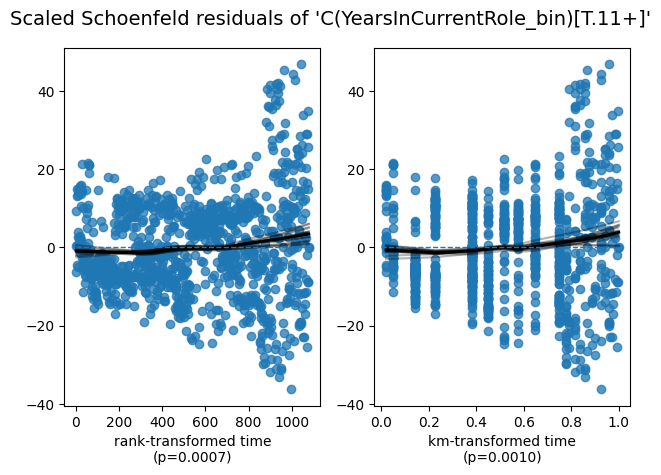

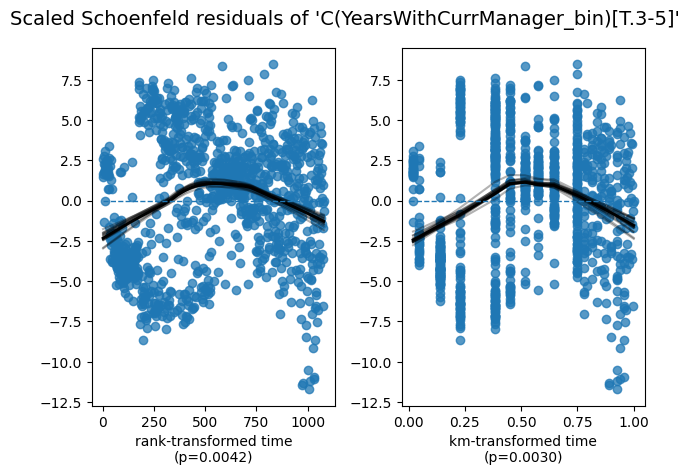

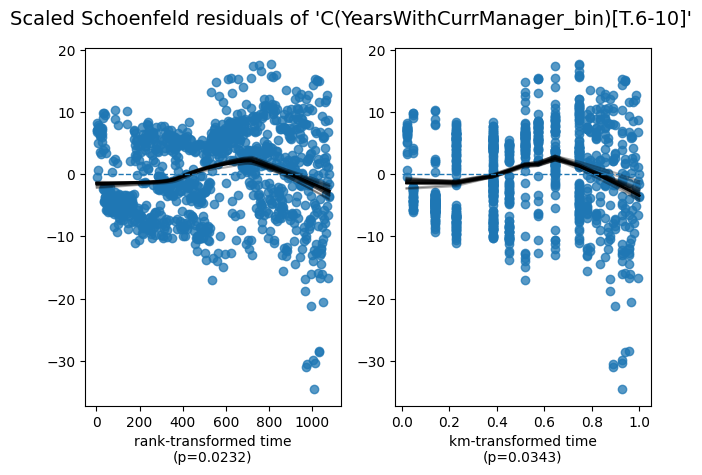

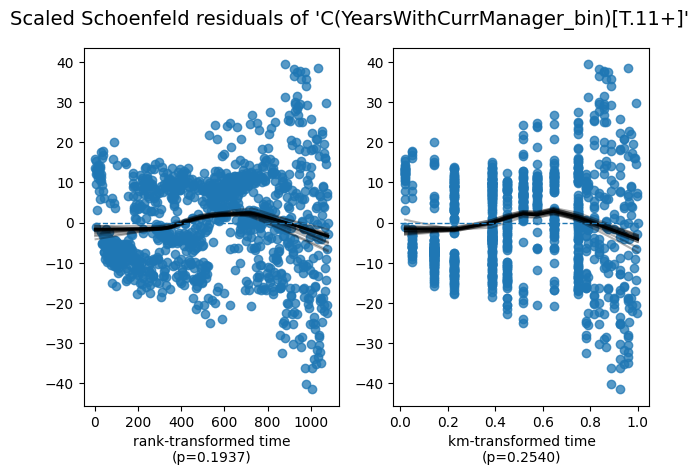

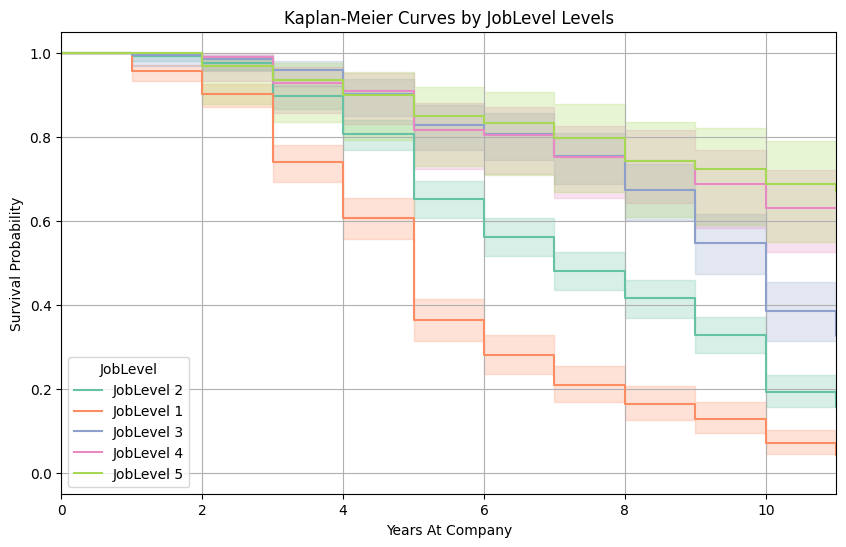

In [24]:
# Filter columns where p-value is less than 0.05
significant_columns = summary[summary['p'] < 0.05]

# Print the names of significant columns
print("The variables with a strong association with promotion are:", significant_columns.index.tolist())

# Plot partial effects for one of the significant covariates
if not significant_columns.empty:
    significant_var = significant_columns.index[0]  # choose the first significant variable for plotting
    cph.plot_partial_effects_on_outcome(covariates=significant_var, values=[df[significant_var].min(), df[significant_var].max()])
    plt.show()

# Check proportional hazards assumption
cph.check_assumptions(df_cox, show_plots=True)

# Fit Kaplan-Meier for significant variables
kmf = KaplanMeierFitter()

# Plot the Kaplan-Meier survival curves for each level of the significant variable
if not significant_columns.empty:
    significant_var = significant_columns.index[0]
    plt.figure(figsize=(10, 6))
    levels = df[significant_var].unique()
    colors = sns.color_palette("Set2", len(levels))

    for i, level in enumerate(levels):
        mask = df[significant_var] == level
        kmf.fit(durations=df['YearsAtCompany'][mask], event_observed=df['PromotionEvent'][mask], label=f'{significant_var} {level}')
        kmf.plot_survival_function(ci_show=True, color=colors[i])

    plt.title(f'Kaplan-Meier Curves by {significant_var} Levels')
    plt.xlabel('Years At Company')
    plt.ylabel('Survival Probability')
    plt.xlim(0, 11)
    plt.legend(title=significant_var)
    plt.grid(True)
    plt.show()

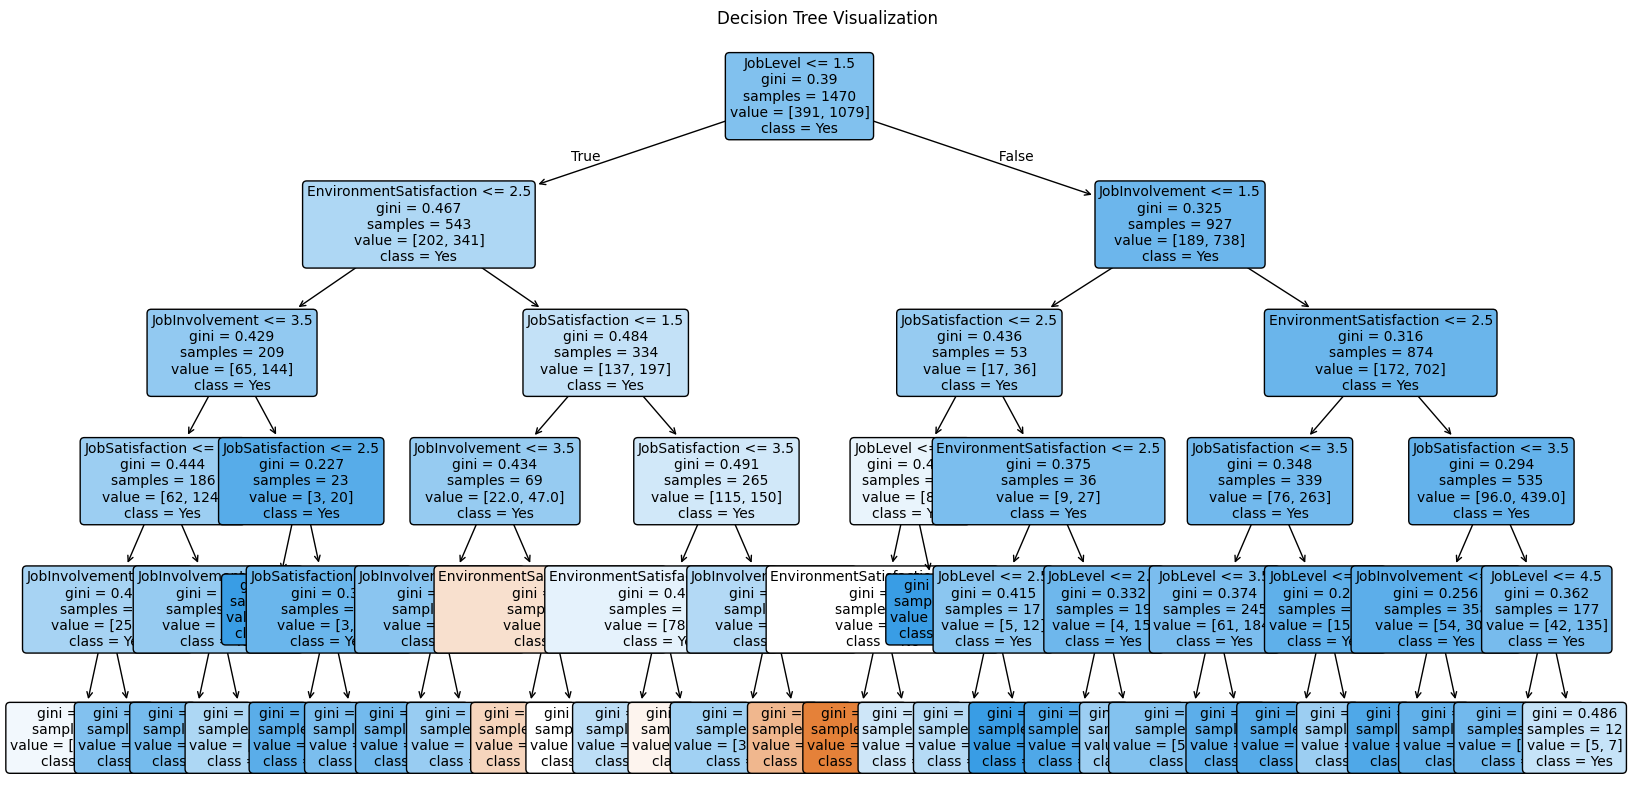

In [57]:
features = ['JobSatisfaction', 'EnvironmentSatisfaction', 'JobLevel', 'JobInvolvement']
X = df[features]
y = df['PromotionEvent']

clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X, y)

plt.figure(figsize=(20, 10))
plot_tree(clf, feature_names=features, class_names=['No', 'Yes'], filled=True, rounded=True, fontsize=10)
plt.title('Decision Tree Visualization')
plt.show()

Feature Weights:
                   Feature    Weight
0          JobSatisfaction  0.090303
1                 JobLevel  0.678896
2           JobInvolvement  0.112963
3  EnvironmentSatisfaction  0.117838
Dataset with Promotion Scores:
      JobSatisfaction  JobLevel  JobInvolvement  EnvironmentSatisfaction  \
0                   4         2               3                        2   
1                   2         2               2                        3   
2                   3         1               2                        4   
3                   3         1               3                        4   
4                   2         1               3                        1   
...               ...       ...             ...                      ...   
1465                4         2               4                        3   
1466                1         3               2                        4   
1467                2         2               4                        2   
1468   

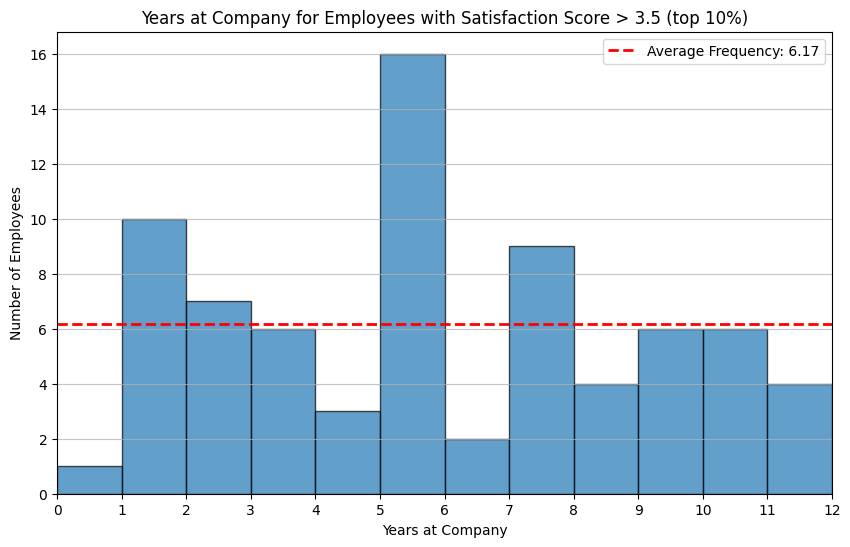

In [63]:
# Prepare the dataset
df['Promotion1'] = df['PromotionEvent'].astype(int)

# Define the features and target
features = ['JobSatisfaction', 'JobLevel', 'JobInvolvement', 'EnvironmentSatisfaction']
X = df[features]
y = df['Promotion1']

# Handle missing values if any
X = X.fillna(X.mean())

# Fit the decision tree classifier
clf = DecisionTreeClassifier(max_depth=3, random_state=42)
clf.fit(X, y)

# Extract feature importances
feature_importances = clf.feature_importances_

# Normalize the feature importances to get weights
feature_weights = feature_importances / feature_importances.sum()

# Create a DataFrame to store feature weights
feature_weights_df = pd.DataFrame({'Feature': features, 'Weight': feature_weights})

# Calculate satisfaction score for each employee
df['SatisfactionScore'] = np.dot(X, feature_weights)

# Display feature weights
print("Feature Weights:")
print(feature_weights_df)

# Display promotion scores
print("Dataset with Promotion Scores:")
print(df[['JobSatisfaction', 'JobLevel', 'JobInvolvement', 'EnvironmentSatisfaction', "SatisfactionScore"]])

# Filter the dataset for promotion scores greater than 3.5 (top 10%)
filtered_df = df[df['SatisfactionScore'] > 3.5]

# Display the filtered dataset with YearsAtCompany
print("Employees with Satisfaction Score > 3.5 (top 10%):")
print(filtered_df[['YearsAtCompany', 'SatisfactionScore']])

# Create a histogram of YearsAtCompany for filtered employees
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(filtered_df['YearsAtCompany'], bins=range(0, 13, 1), edgecolor='black', alpha=0.7)

# Calculate and plot the average frequency line
average_frequency = n.mean()
plt.axhline(average_frequency, color='red', linestyle='dashed', linewidth=2, label=f'Average Frequency: {average_frequency:.2f}')

plt.title('Years at Company for Employees with Satisfaction Score > 3.5 (top 10%)')
plt.xlabel('Years at Company')
plt.ylabel('Number of Employees')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0, 12)
plt.xticks(range(0, 13, 1))
plt.legend()
plt.show()



Mean Satisfaction Score for Promoted Employees: 3.8086981618782825
Mean Satisfaction Score for Not Promoted Employees: 3.2262764109121904


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


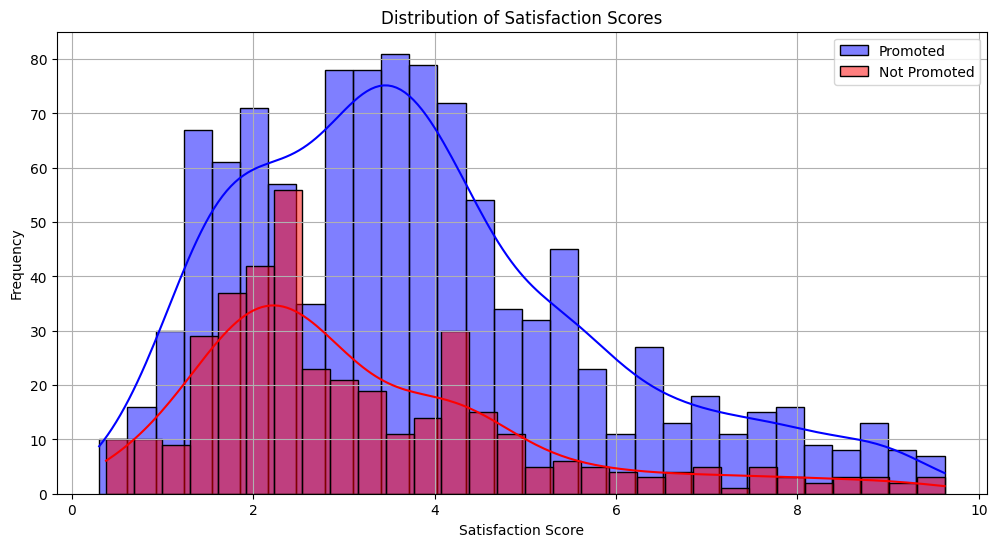

In [28]:
import seaborn as sns

weights = {
    'JobSatisfaction':  0.090303,
    'JobLevel':  0.678896,
    'JobInvolvement':  0.112963,
    'EnvironmentSatisfaction':  0.117838
}

# Normalize the scores for each factor to a scale of 0 to 10
for factor in weights.keys():
    df[f'{factor}_normalized'] = (df[factor] - df[factor].min()) / (df[factor].max() - df[factor].min()) * 10

# Compute the composite Satisfaction score
df['SatisfactionScore'] = sum(df[f'{factor}_normalized'] * weight for factor, weight in weights.items())

# Separate the groups
promoted = df[df['PromotionEvent'] == True]
not_promoted = df[df['PromotionEvent'] == False]

# Calculate mean Satisfaction scores for both groups
mean_promoted_score = promoted['SatisfactionScore'].mean()
mean_not_promoted_score = not_promoted['SatisfactionScore'].mean()

print(f"Mean Satisfaction Score for Promoted Employees: {mean_promoted_score}")
print(f"Mean Satisfaction Score for Not Promoted Employees: {mean_not_promoted_score}")

# Visualize the distribution of Satisfaction scores
plt.figure(figsize=(12, 6))
sns.histplot(promoted['SatisfactionScore'], color='blue', label='Promoted', kde=True, bins=30)
sns.histplot(not_promoted['SatisfactionScore'], color='red', label='Not Promoted', kde=True, bins=30)
plt.title('Distribution of Satisfaction Scores')
plt.xlabel('Satisfaction Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


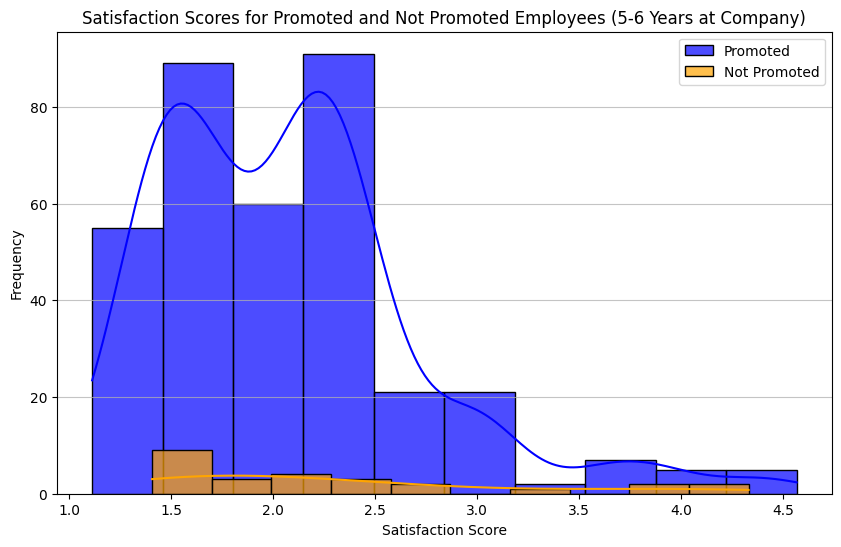

In [80]:
# Filter the dataset for employees with 4-6 years at the company
filtered_df = df[(df['YearsAtCompany'] >= 4) & (df['YearsAtCompany'] <= 6)]

# Separate the data into promoted and not promoted groups
promoted = filtered_df[filtered_df['PromotionEvent'] == 1]
not_promoted = filtered_df[filtered_df['PromotionEvent'] == 0]

# Plot the satisfaction scores for each group
plt.figure(figsize=(10, 6))
sns.histplot(promoted['SatisfactionScore'], bins=10, kde=True, color='blue', label='Promoted', alpha=0.7)
sns.histplot(not_promoted['SatisfactionScore'], bins=10, kde=True, color='orange', label='Not Promoted', alpha=0.7)

plt.title('Satisfaction Scores for Promoted and Not Promoted Employees (5-6 Years at Company)')
plt.xlabel('Satisfaction Score')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()


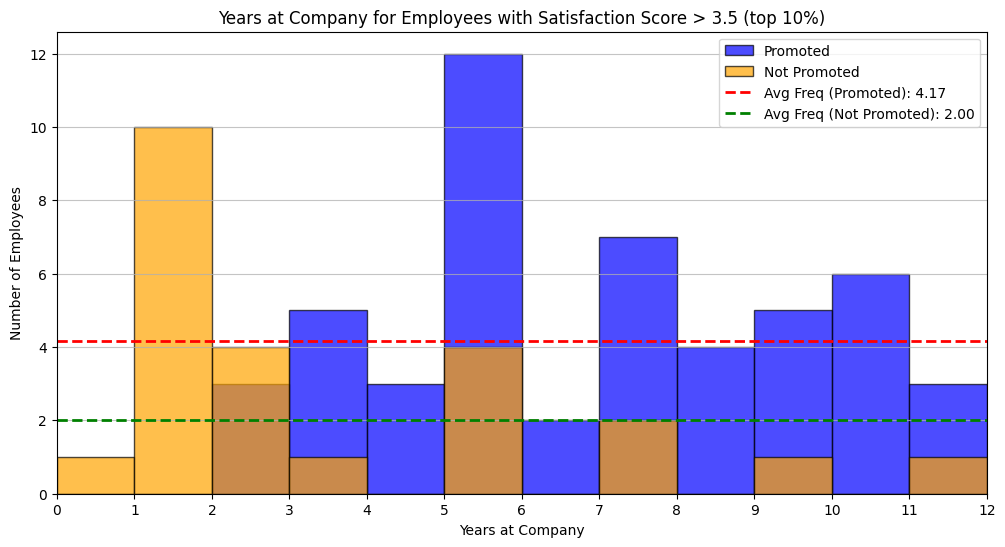

In [3]:
# Plot histograms of YearsAtCompany for both groups
plt.figure(figsize=(12, 6))

plt.hist(promoted['YearsAtCompany'], bins=range(0, 13, 1), edgecolor='black', alpha=0.7, label='Promoted', color='blue')
plt.hist(not_promoted['YearsAtCompany'], bins=range(0, 13, 1), edgecolor='black', alpha=0.7, label='Not Promoted', color='orange')

# Calculate and plot the average frequency line for promoted group
average_frequency_promoted = np.histogram(promoted['YearsAtCompany'], bins=range(0, 13, 1))[0].mean()
plt.axhline(average_frequency_promoted, color='red', linestyle='dashed', linewidth=2, label=f'Avg Freq (Promoted): {average_frequency_promoted:.2f}')

# Calculate and plot the average frequency line for not promoted group
average_frequency_not_promoted = np.histogram(not_promoted['YearsAtCompany'], bins=range(0, 13, 1))[0].mean()
plt.axhline(average_frequency_not_promoted, color='green', linestyle='dashed', linewidth=2, label=f'Avg Freq (Not Promoted): {average_frequency_not_promoted:.2f}')

plt.title('Years at Company for Employees with Satisfaction Score > 3.5 (top 10%)')
plt.xlabel('Years at Company')
plt.ylabel('Number of Employees')
plt.grid(axis='y', alpha=0.75)
plt.xlim(0, 12)
plt.xticks(range(0, 13, 1))
plt.legend()
plt.show()
